# 💻 Overlay


Overlay-analyser er GIS-operasjoner der to eller flere vektorlag er
kombinert for å produsere nye geometrier. Typiske overlay-operasjoner inkluderer *union*,
*intersection*, og *difference* - navngitt etter resultatet av kombinasjonen av to lag. I denne notebooken (inspirert av [Python for Geographic Data Analysis](https://pythongis.org/part2/chapter-06/nb/08-overlay-analysis-with-vector-data.html)) ser vi nærmere på hvordan vi kan utføre overlay operasjoner med vektor data.

Den grunnleggende ideen med vektor-overlay-operasjoner er demonstrert i figuren under, hvor de grønne områdene representerer områdene som utgjør resultatet etter overlay-operasjonen. Det er viktig å huske at overlays opererer på GeoDataFrame-nivå, ikke på individuelle geometrier, og egenskapene fra begge beholdes (ofte, men ikke alltid). I praksis utføres denne operasjonen for hver form i den venstre GeoDataFrame mot hver annen form i den høyre GeoDataFrame.

![Fire paneler som viser union, intersection, symmetric difference og difference av to geometrier.](https://pythongis.org/_images/vector_overlay_processes.png)


Romlig overlay med to inputvektorlag (rektangel, sirkel). Det resulterende vektorlaget vises i grønt. *Kilde: [QGIS dokumentasjon](https://docs.qgis.org/latest/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html#figure-overlay-operations)*
:::

For å demonstrere hvordan disse overlay-operasjonene fungerer i praksis, vil vi utføre vektor-overlay-operasjoner mellom to polygon-datasett som representerer 1) bydelene i Oslo og 2) en 5000-meter buffer rundt Oslo S. La oss starte med å lese inn datasettene og forberede dem for analysen:

In [1]:
import geopandas
import pathlib 

NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

bydeler = geopandas.read_file(DATA_MAPPE / "oslo_bydeler" / "oslo_bydeler_befolkning_2024.geojson")
oslo_s = geopandas.read_file(DATA_MAPPE / "oslo_bydeler" / "oslo_s.geojson")
bydeler.shape

(17, 6)

In [2]:
oslo_s.head()

,navn,geometry
0,Oslo S,POINT (10.7504 59.9117)


Her kan vi se at bydelene inneholder MultiPolygon-geometrier som representerer til sammen 17 bydeler, mens `oslo_s` representerer et enkelt punkt for Oslo S. Siden vektor-overlay-operasjoner skjer mellom to geografiske datasett, er det nødvendig å sikre at de begge deler samme koordinatsystem og i vårt tilfelle et projisert koordinatsystem, siden vi skal bruke en metrisk buffersone.
La oss derfor først sjekke crs-attributtene og gjøre nødvendige reprojiseringer:

In [3]:
print(bydeler.crs)
print(oslo_s.crs)

EPSG:4326
EPSG:4326


Begge datasettene våre er i `EPSG:4326`, la oss reprojisere til `EPSG:25832` som egner seg for norske data:

In [4]:
# Reprojiser bydeler
bydeler = bydeler.to_crs("EPSG:25832")

# Reprojiser oslo_s
oslo_s = oslo_s.to_crs(bydeler.crs)


La oss for sikkerhetsskyld dobbeltsjekke at lagene har samme crs:

In [5]:
assert bydeler.crs == oslo_s.crs, "Ulike koordinatsystemer!"

Supert, koordinatsystemet (CRS) stemmer overens mellom lagene. Derfor kan vi fortsette og lage en 5 kilometer buffer rundt Oslo S som vi vil bruke i våre vektor-overlay-operasjoner:

In [6]:
oslo_s_buffer = oslo_s.copy()
oslo_s_buffer["geometry"] = oslo_s_buffer.buffer(5000)

Her har vi først lagd en kopi av `oslo_s`-laget vårt, og brukt `.buffer()`-metoden til å lage en buffer Polygon på 5000 meters radius rundt Oslo S. Vi kan nå lage et enkelt plot for å se hvordan lagene overlapper hverandre:

<Axes: >

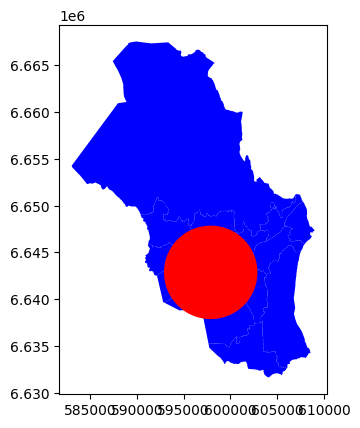

In [7]:
ax = bydeler.plot(facecolor="blue")
oslo_s_buffer.plot(ax=ax, facecolor="red")

## Intersection

Nå kan vi utføre en overlay-analyse mellom disse to lagene. Vi skal lage et nytt lag som `intersect`("skjærer") med bydelslaget. Vi bruker da metoden `.overlay()` i GeoPandas til å gjøre analysen mellom laget `bydeler` og `oslo_s_buffer`. Parameteren `how` i `overlay()`-metoden angir hvilken type overlay-analyse som utføres. De ulike metodene man kan velge mellom er `intersection`, `union`, `symmetric_difference`, `difference` og `identity`.

Vi begynner med å bruke `intersection` som overlay-metode:

In [8]:
# Intersection
intersection = bydeler.overlay(oslo_s_buffer, how="intersection")
intersection

,fid,bydelsnr,bynavn,bydel,befolkning_2024,navn,geometry
0,1,030101,Oslo,Gamle Oslo,63721,Oslo S,"POLYGON ((594299.813 6640496.194, 595053.786 6..."
1,2,030102,Oslo,Grünerløkka,65532,Oslo S,"POLYGON ((598106.885 6643240.277, 598165.757 6..."
2,3,030103,Oslo,Sagene,47627,Oslo S,"POLYGON ((599000.023 6645042.516, 598989.131 6..."
3,4,030104,Oslo,St.Hanshaugen,41571,Oslo S,"POLYGON ((597929.403 6643709.551, 597936.146 6..."
4,5,030105,Oslo,Frogner,60727,Oslo S,"POLYGON ((593123.834 6643198.372, 593664.254 6..."
5,6,030106,Oslo,Ullern,35440,Oslo S,"POLYGON ((592894.411 6643050.452, 592909.701 6..."
6,7,030107,Oslo,Vestre Aker,52590,Oslo S,"POLYGON ((595764.88 6647391.522, 595759.932 66..."
7,8,030108,Oslo,Nordre Aker,55056,Oslo S,"POLYGON ((599513.141 6646064.846, 599498.522 6..."
8,9,030109,Oslo,Bjerke,36450,Oslo S,"POLYGON ((601049.467 6644203.445, 601046.649 6..."
9,12,030112,Oslo,Alna,50358,Oslo S,"POLYGON ((601433.698 6642738.788, 601426.332 6..."


Vi kan nå se at vi har en GeoDataFrame med 13 rader for alle bydelene som intersecter med bufferlaget vårt. Vi kan også se at vi har med kolonner fra begge datasettene, og dermed at overaly-metoden fungerer litt likt `sjoin()` som vi brukte i en [tidligere forelesning](#05_romlig_kobling).

For å lettere illustrere hvordan de ulike overlay metodene fungerer, lager vi nå en funksjon som plotter et kart før og etter overlay-analysen ved siden av hverandre:

In [9]:
import matplotlib.pyplot as plt


def plot_overlay(gdf1, gdf2, result, title):
    """
    Creates two maps next to each other based on `gdf1`, `gdf2` and the
    `result` GeoDataFrames.

    Source: https://pythongis.org/part2/chapter-06/nb/08-overlay-analysis-with-vector-data.html#intersection
    """

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

    ax1 = gdf1.plot(ax=ax1)
    ax1 = gdf2.plot(ax=ax1, color="red", alpha=0.3)

    result.plot(ax=ax2)

    # Fetch bounds and apply to axis 2
    xmin, ymin, xmax, ymax = gdf1.total_bounds

    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)

    fig.suptitle(title, fontsize=16)
    # Add an arrow between the plots
    fig.text(0.49, 0.5, "⇨", fontsize=30, color="red")
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()
    return fig, ax1, ax2

Med denne funksjonen kan vi nå bruke `intersection`-laget vi nettopp lagde og plotte før- og etter-resultatet:

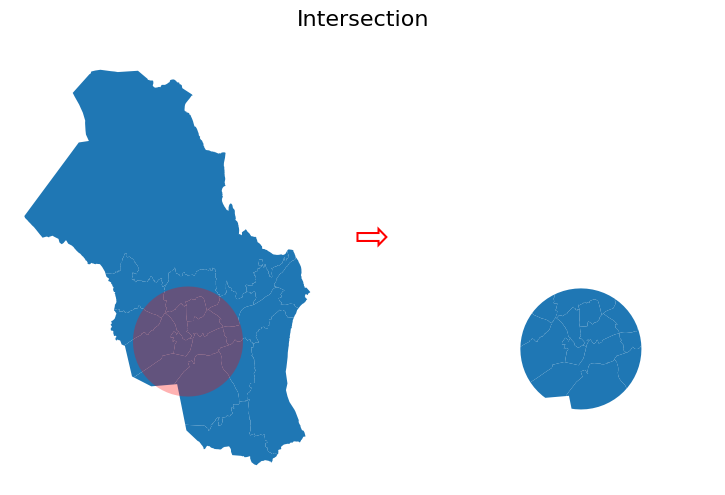

In [10]:
fig, ax1, ax2 = plot_overlay(
    gdf1=bydeler, gdf2=oslo_s_buffer, result=intersection, title="Intersection"
)

Som vi kan se, beholder "intersection" operasjonen bydelene som krysser sirkelen og beholder alle disse geometriene i resultatet. En viktig ting å merke seg er at med `overlay()` vil den kryssende GeoDataFramen (`oslo_s_buffer`) også modifisere inputgeometriene ved å kutte dem i grenseområdene der de krysser. Dette er en av de viktigste forskjellene mellom `.overlay()` og `sjoin()` metodene, da `sjoin()` ikke vil modifisere inputgeometriene. Som nevnt tidligere, beholdes attributtdata fra begge GeoDataFramene for objektene som er en del av resultatet. I det følgende vil vi vise én etter én hvordan forskjellige overlay-operasjoner (dvs. union, difference, symmetric difference, identity) påvirker resultatene.

## Union

La oss bruke de samme inputdatasettene og utføre en `union`-overlay:

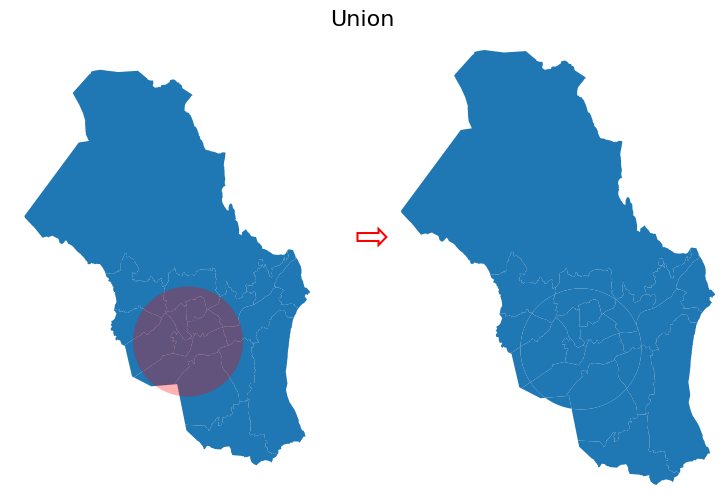

In [11]:
# Union
union = bydeler.overlay(oslo_s_buffer, how="union")

fig, ax1, ax2 = plot_overlay(
    gdf1=bydeler, gdf2=oslo_s_buffer, result=union, title="Union"
)

In [12]:
union.shape

(27, 7)

Når man bruker `"union"` overlay-operasjonen, beholdes geometriene fra begge GeoDataFrames i resultatet. Som du kan se, har antall rader økt ganske betydelig fra 17 til 22 rader. Dette skjer fordi bydelene igjen blir modifisert av `oslo_s_buffer` i områdene der geometriene krysser hverandre: bydelene blir delt i to i områder der buffergeometrien krysser bydeler-geometriene. Dette vil derfor øke antall rader i det endelige resultatet.

## Difference og symmetric difference

Noen ganger kan det være nyttig å fokusere på å trekke ut geometrier som ligger utenfor et gitt lag. Dette kan oppnås ved å bruke .overlay() med "difference" operatoren:

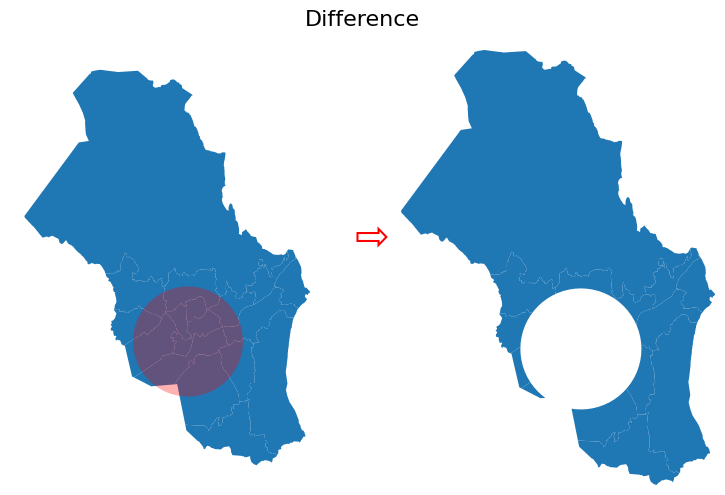

In [13]:
# Difference
difference = bydeler.overlay(oslo_s_buffer, how="difference")

fig, ax1, ax2 = plot_overlay(
    gdf1=bydeler, gdf2=oslo_s_buffer, result=difference, title="Difference"
)


In [14]:
difference.shape

(13, 6)

Symmetric differance-overlay-operasjonen er en interessant en. Den vil beholde geometriene og attributtene utenfor `oslo_s_buffer`-laget, samt opprette en geometri innenfor `oslo_s_buffer` som inkluderer områder som er innenfor `oslo_s_buffer`-ringen, men utenfor `bydeler`-GeoDataFramen. Det vil si, i vårt tilfelle inneholder den et lite stykke av Oslofjorden, som vist nedenfor:

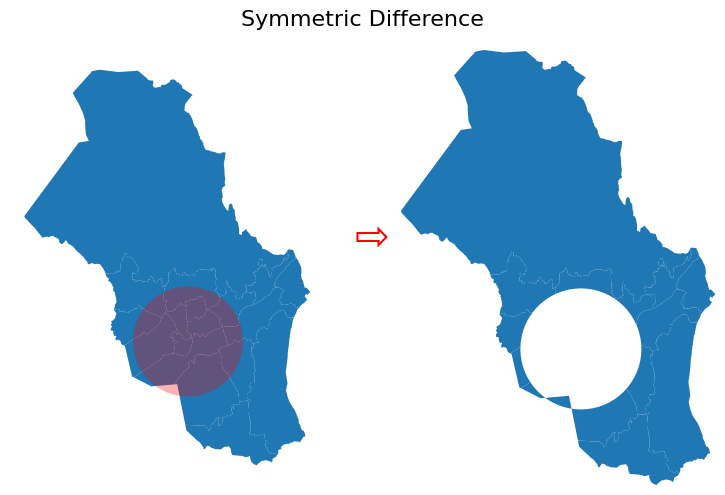

In [15]:
# Symmetric Difference
symmetric_difference = bydeler.overlay(oslo_s_buffer, how="symmetric_difference")

fig, ax1, ax2 = plot_overlay(
    gdf1=bydeler,
    gdf2=oslo_s_buffer,
    result=symmetric_difference,
    title="Symmetric Difference",
)


In [16]:
symmetric_difference.shape

(14, 7)

In [17]:
symmetric_difference.tail()

,fid,bydelsnr,bynavn,bydel,befolkning_2024,navn,geometry
9,13.0,030113,Oslo,Østensjø,51895.0,NaN,"POLYGON ((603544.866 6638682.313, 603551.763 6..."
10,14.0,030114,Oslo,Nordstrand,54027.0,NaN,"POLYGON ((600631.693 6635249.786, 600624.152 6..."
11,15.0,030115,Oslo,Søndre Nordstrand,39124.0,NaN,"MULTIPOLYGON (((603567.643 6634836.359, 603565..."
12,17.0,030117,Oslo,Marka,0.0,NaN,"MULTIPOLYGON (((603567.643 6634836.359, 603567..."
13,NaN,NaN,NaN,NaN,NaN,Oslo S,"MULTIPOLYGON (((596434.202 6638086.898, 595972..."


Som vi kan se i tabellen, så inneholder tabellen attributter fra bydelene og en rad med data fra `oslo_s_buffer` i den siste raden.

## Overlay med befolkningsdata

I denne notebooken vil vi utføre en overlay-analyse for å velge de polygon-cellene i et grid-datasett som ligger innenfor Oslo. I denne
øvelsen, bruker vi to input-datasett: et grid av statistiske polygoner med
befolkningen i Oslo og et polygon-datasett av norske kommuner
(`kommuner.geojson`), hvor vi skal velge bare Oslo kommune.

In [18]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [19]:
import geopandas

rutenett = geopandas.read_file(DATA_MAPPE / "ssb_rutenett" / "befolkning_250m_2023_akershus.shp")

kommuner = geopandas.read_file(
    DATA_MAPPE / "kommuner" / "kommuner.geojson"
)

display(kommuner.head())

,gml_id,lokalId,navnerom,versjonId,oppdateringsdato,gyldigFra,datauttaksdato,navn,språk,kommunenummer,kommunenavn,samiskForvaltningsområde,geometry
0,kommune.1,0466e7c3-6a23-4b70-97d4-cf81f949490b,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 17:47:39,2024-01-01,2024-03-04 12:27:57,Ibestad,nor,5514,Ibestad,False,"MULTIPOLYGON (((589669.263 7630312.979, 589669..."
1,kommune.2,0f821a2d-a307-41ec-9b64-f01c80e39357,https://data.geonorge.no/sosi/inndelinger/innd...,4,2023-11-07 23:33:28,2023-11-07,2024-03-04 12:27:57,Rendalen,nor,3424,Rendalen,False,"MULTIPOLYGON (((327391.89 6869419.57, 327363.6..."
2,kommune.3,251a3fdd-ac96-4ef2-badb-a9b75e6ab2e6,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 15:42:05,2024-01-01,2024-03-04 12:27:57,Rakkestad,nor,3120,Rakkestad,False,"MULTIPOLYGON (((284560.99 6591094.55, 284575.8..."
3,kommune.4,2758a7b8-edba-4d6a-936e-4754ce03ca8f,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 15:56:10,2024-01-01,2024-03-04 12:27:57,Nordre Follo,nor,3207,Nordre Follo,False,"MULTIPOLYGON (((269615.27 6638265.47, 269615.2..."
4,kommune.5,340fff7f-b153-4a87-814d-12ca4f2d1682,https://data.geonorge.no/sosi/inndelinger/innd...,4,2023-11-07 23:33:28,2023-11-07,2024-03-04 12:27:57,Overhalla,nor,5047,Overhalla,False,"MULTIPOLYGON (((359415.1 7152572.93, 359412.81..."


Vi kan nå velge bare Ås kommune fra kommune-datasettet.

In [20]:
aas = kommuner.loc[kommuner["navn"] == "Ås"]
aas.head()

,gml_id,lokalId,navnerom,versjonId,oppdateringsdato,gyldigFra,datauttaksdato,navn,språk,kommunenummer,kommunenavn,samiskForvaltningsområde,geometry
27,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 16:00:22,2024-01-01,2024-03-04 12:27:57,Ås,nor,3218,Ås,False,"MULTIPOLYGON (((266871.58 6614231.5, 266871.14..."


Før vi fortsetter er det en god ide å sørge for at begge lagene har samme koordinatsystem:

In [21]:
# Sjekke at lagene har samme crs
rutenett.crs == aas.crs

True

La oss gjøre en rask overleggsvisualisering av de to lagene:

<Axes: >

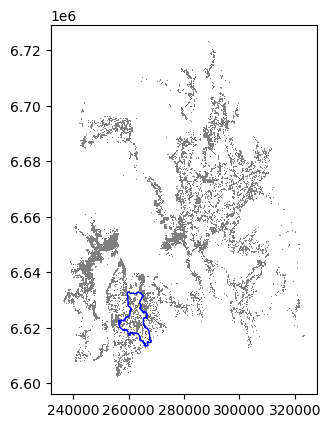

In [22]:
# Plott lagene
ax = rutenett.plot(color="gray")
aas.plot(ax=ax, facecolor="None", edgecolor="blue")

Her er alle de grå rutene gridceller med befolkningsdata for Akershus fylke. Datasettet inneholder 17376 ruter.
Det blå omrisset representerer Ås kommune. Vårt mål er nå å utføre en overlay-analyse og velge de geometriene fra rutenettet som krysser polygonet for Ås kommune.

Vi vil lage et nytt lag basert på rutenett-polygoner som `intersect`-er med Ås-laget vårt. Vi kan bruke metoden `overlay()` med en `GeoDataFrame` for å utføre overlay-analysen som tar som en input 1) andre GeoDataFrames, og 2)
parameteren `how` som kan brukes til å kontrollere hvordan overlay-analysen blir
utført (mulige verdier er `'intersection'`, `'union'`,`'symmetric_difference'`, `'difference'`, og `'identity'`):

In [23]:
intersection = rutenett.overlay(aas, how="intersection")

La oss plotte dataene våre og se hva vi har:

<Axes: >

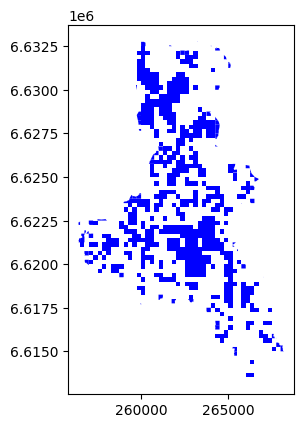

In [24]:
intersection.plot(color="b")

Som et resultat har vi nå bare de rutenett cellene som krysser med grensene til Ås. Hvis du ser nøye etter, kan du også observere at **rutenett cellene er
klippet basert på grensen.**

- Hva med dataattributter? La oss se hva vi har:

In [25]:
intersection.head()

,ru250m,pop_tot,gml_id,lokalId,navnerom,versjonId,oppdateringsdato,gyldigFra,datauttaksdato,navn,språk,kommunenummer,kommunenavn,samiskForvaltningsområde,geometry
0,22605006625250,10,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 16:00:22,2024-01-01,2024-03-04 12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((260500 6625250, 260500 6625500, 2607..."
1,22617506625250,3,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 16:00:22,2024-01-01,2024-03-04 12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((261750 6625250, 261750 6625500, 2620..."
2,22620006625250,23,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 16:00:22,2024-01-01,2024-03-04 12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((262000 6625250, 262000 6625500, 2622..."
3,22622506625250,10,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 16:00:22,2024-01-01,2024-03-04 12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((262250 6625250, 262250 6625500, 2625..."
4,22625006625250,14,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28 16:00:22,2024-01-01,2024-03-04 12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((262500 6625250, 262500 6625500, 2627..."


Som vi kan se, på grunn av overleggsanalysen, inneholder datasettet attributtene
fra begge input lagene.

La oss lagre resultatrutenettet vårt som en GeoPackage.

In [26]:
intersection.to_file(DATA_MAPPE / "intersection.geojson")

Det er mange flere eksempler på forskjellige typer overleggsanalyse i
[Geopandas dokumentasjon](http://geopandas.org/set_operations.html) hvor du
kan gå og lære mer.